In [1]:
import numpy as np 
import torch 
import torchvision 
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms, models 
import matplotlib.pyplot as plt 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#define Hyperparameters 
in_channels = 3 
alpha = 1e-3
batch_size = 128
epochs = 10 

In [4]:
#Function Definition for training 
#Inputs: model, data loaders for train + validation, loss function, optimizer, # epochs 
#GPU/CPU 
#outputs: none 
#Does: Trains model against new dataset, updates weights and prints training/validation 
#loss and accuracy 
def train_model(model, data_loaders, criterion, optimizer, epochs, device):
  loss_plot = []
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
  lrs = []
  for epoch in range(epochs):
    
    #State current epoch 
    print("Epoch %d / %d" % (epoch, epochs-1))
    print("-"*10)

    #either train or evaluate based on dataset 
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else: 
        model.eval()
      
      running_loss = 0.0 
      correct = 0 

      #Load data in batches 
      for x_batch, y_batch in data_loaders[phase]: 
        x_var = x_batch.to(device)
        y_var = y_batch.to(device)

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(x_var)
          loss = criterion(outputs, y_var)

          _, preds = torch.max(outputs,1)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        loss_plot.append(loss.item())
        running_loss +=loss.item() * x_var.size(0)
        correct += torch.sum(preds == y_var.data)
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
        
    
    epochLoss = running_loss / len(data_loaders[phase].dataset)
    epochAcc = 100 * (correct.double() / len(data_loaders[phase].dataset))

    print('Phase: {}, current Epoch loss: {:.4f}, accuracy: {:.2f} %'.format(phase, epochLoss, epochAcc))
  
  plt.plot(range(len(loss_plot)), loss_plot, '-')
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

In [5]:
def test_model(model, data_loader, device): 
  correct = 0
  for batch_idx, (x_batch, y_batch) in enumerate(data_loader):
    x_test = x_batch.to(device)
    y_test = y_batch.to(device)
    y_pred = model(x_test)

    _, preds = torch.max(y_pred, 1)
    correct += torch.sum(preds == y_test.data)

  accuracy = 100 * (correct.double() / len(data_loader.dataset))

  print("Test Set Accuracy: {:.2f}".format(accuracy))

In [6]:
def parameter_gradients(model, detach):
  if detach:
    for param in model.parameters():
      param.requires_grad = False

In [7]:
train_val_set = torchvision.datasets.GTSRB(root='./data', split = "train", 
                                           transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),
                                                           transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))]), 
                                           download = True)

train_set, val_set = torch.utils.data.random_split(train_val_set, [21000,5640])

#print(train_set.dataset) 
#print(train_set)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True)

val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                           batch_size = batch_size,
                                           shuffle = True)

data_loaders = {}

data_loaders['train'] = train_loader 
data_loaders['val'] = val_loader

  0%|          | 0/187490228 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


In [8]:
#Import pretrained resnet weights 
model = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
#You're able to verify what the minimum required input size is for a model by simply googling 
#32x32 is the min for ResNet50, so at first I tried transforming input from GTSRB to 32x32

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
#Swap the final fully connected layer in the neural net to classify over current 
#GTSRB dataset
parameter_gradients(model, True)
model.fc = nn.Linear(in_features = 2048, out_features = 43, bias = True)
model = model.to(device)

In [10]:
update_params = []
for name, param in model.named_parameters():
  if param.requires_grad:
    update_params.append(param)
    print('\n', name)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = alpha)


 fc.weight

 fc.bias


Epoch 0 / 9
----------
Phase: val, current Epoch loss: 1.2424, accuracy: 71.72 %
Epoch 1 / 9
----------
Phase: val, current Epoch loss: 0.8366, accuracy: 81.33 %
Epoch 2 / 9
----------
Phase: val, current Epoch loss: 0.6703, accuracy: 85.09 %
Epoch 3 / 9
----------
Phase: val, current Epoch loss: 0.5859, accuracy: 86.84 %
Epoch 4 / 9
----------
Phase: val, current Epoch loss: 0.5137, accuracy: 88.03 %
Epoch 5 / 9
----------
Phase: val, current Epoch loss: 0.4667, accuracy: 88.94 %
Epoch 6 / 9
----------
Phase: val, current Epoch loss: 0.4261, accuracy: 89.96 %
Epoch 7 / 9
----------
Phase: val, current Epoch loss: 0.3910, accuracy: 90.09 %
Epoch 8 / 9
----------
Phase: val, current Epoch loss: 0.3909, accuracy: 90.73 %
Epoch 9 / 9
----------
Phase: val, current Epoch loss: 0.3868, accuracy: 90.44 %


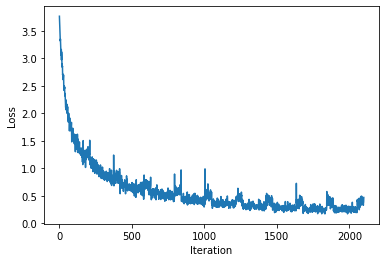

In [11]:
train_model(model, data_loaders, criterion, optimizer, epochs, device)

In [12]:
#download and load the test dataset 
test_dataset = torchvision.datasets.GTSRB(root='./data', split = "test", 
                                           transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),
                                                           transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))]), 
                                           download = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

  0%|          | 0/88978620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


  0%|          | 0/99620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [13]:
#Now that the model is trained and validated (90% accuracy), we can test it against 
#our test set 
test_model(model, test_loader, device)

Test Set Accuracy: 66.14


Data augmentation strategy breakdown: 

1. Compare amount of data in set for each class 
2. Find a minimal point for number of data points we would like to have for each class 
3. For classes that don't satisfy this threshold, create new data that's augmented off of the original data 